## Select articles: look for hateful comments

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from mongoengine import connect
from hatespeech_models import Tweet, Article

client = connect("hatespeech-labelling")
db = client["hatespeech-labelling"]

In [2]:
Article.objects.count()

55110

In [3]:
initial_query = {
    "comments__19__exists": True,
}
articles = Article.objects(**initial_query).as_pymongo()
articles = list(articles)

print(len(articles))


6519


[737400. 737450. 737500. 737550. 737600. 737650. 737700.]


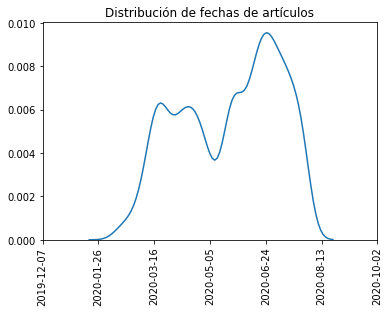

In [4]:
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.pyplot as plt

dates_dist = [a["created_at"] for a in articles]
ordinal_dates = [d.toordinal() for d in dates_dist]
sns.distplot(ordinal_dates, kde=True, hist=False)

locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos");

In [5]:
for article in articles:
    hateful_comments = [c for c in article["comments"] if c["hateful_value"] > 0.5]
    
    article["num_hateful_comments"] = len(hateful_comments)
    article["avg_hateful_comments"] = len(hateful_comments) / len(article["comments"])
    article["avg_hate_value"] = sum(c["hateful_value"] for c in article["comments"]) / len(article["comments"])


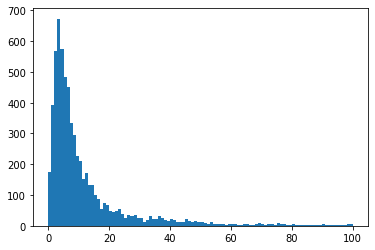

In [6]:
import matplotlib.pyplot as plt

plt.hist([c["num_hateful_comments"] for c in articles], range=[0, 100], bins=100);

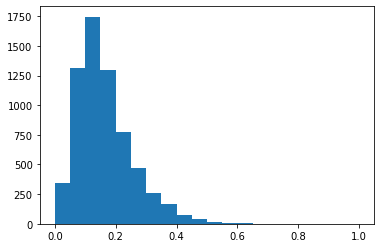

In [7]:
import matplotlib.pyplot as plt

plt.hist([c["avg_hate_value"] for c in articles], range=[0, 1], bins=20);

[737400. 737450. 737500. 737550. 737600. 737650. 737700.]


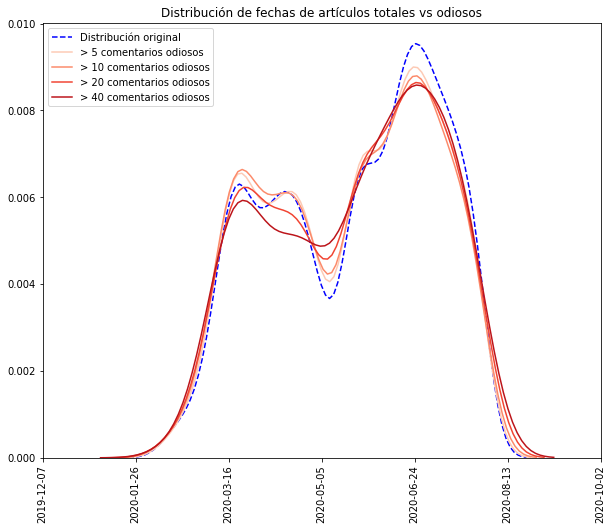

In [8]:
import random
random.seed(2020)


thresholded_hateful_articles_by_num = {
    k:[art for art in articles if art["num_hateful_comments"] >= k]
    
    for k in [5, 10, 20, 40]
}

plt.figure(figsize=(10, 8))
sns.distplot(ordinal_dates, kde=True, hist=False, color="blue", label="Distribución original", kde_kws={"linestyle": "--"})

colors = sns.color_palette("Reds", len(thresholded_hateful_articles_by_num))

for i, (k, hateful_articles) in enumerate(thresholded_hateful_articles_by_num.items()):
    hateful_dates = [art["created_at"].toordinal() for art in hateful_articles]
    sns.distplot(
        hateful_dates, kde=True, hist=False,
        label=f"> {k} comentarios odiosos",
        color=colors[i],
    )


locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos totales vs odiosos");

[737400. 737450. 737500. 737550. 737600. 737650. 737700.]


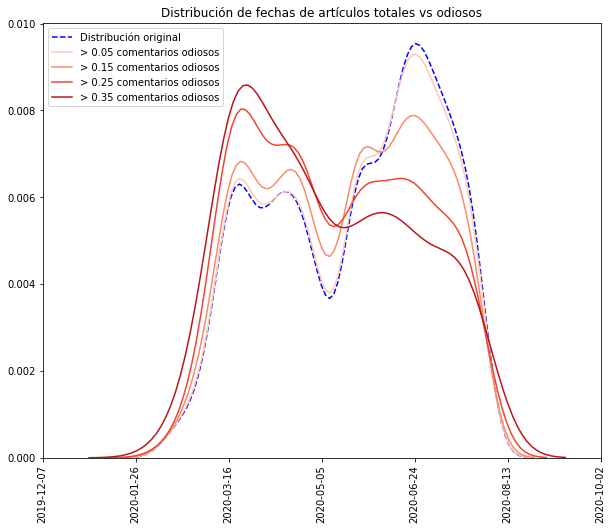

In [9]:
import random
import numpy as np

random.seed(2020)


thresholded_hateful_articles_by_comments_avg = {
    k:[art for art in articles if art["avg_hateful_comments"] > k]
    
    for k in np.arange(0.05, 0.45, 0.1)
}

plt.figure(figsize=(10, 8))
sns.distplot(ordinal_dates, kde=True, hist=False, color="blue", label="Distribución original", kde_kws={"linestyle": "--"})

colors = sns.color_palette("Reds", len(thresholded_hateful_articles_by_comments_avg))

for i, (k, hateful_articles) in enumerate(thresholded_hateful_articles_by_comments_avg.items()):
    hateful_dates = [art["created_at"].toordinal() for art in hateful_articles]
    sns.distplot(
        hateful_dates, kde=True, hist=False,
        label=f"> {k:.2f} comentarios odiosos",
        color=colors[i],
    )


locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos totales vs odiosos");
plt.savefig("pepe.png")

{0.05: 6175, 0.1: 4859, 0.15000000000000002: 3113, 0.2: 1819, 0.25: 1043, 0.3: 569, 0.35000000000000003: 306, 0.4: 138}
[737400. 737450. 737500. 737550. 737600. 737650. 737700.]


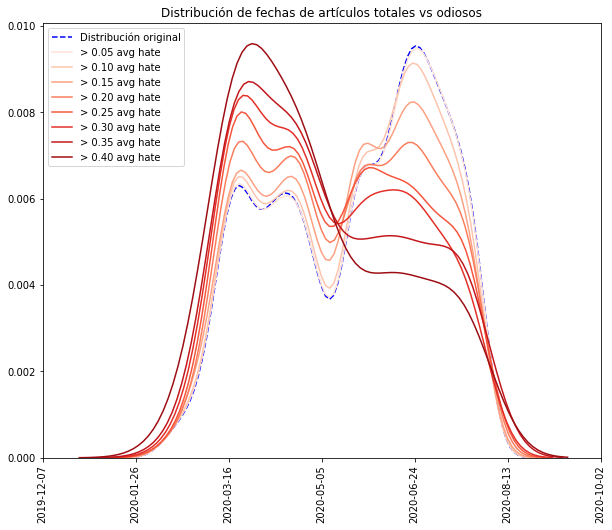

In [10]:
import random
import numpy as np

random.seed(2020)


thresholded_hateful_articles = {
    k:[art for art in articles if art["avg_hate_value"] > k]
    
    for k in np.arange(0.05, 0.45, 0.05)
}
print({k:len(art) for k, art in thresholded_hateful_articles.items()})

plt.figure(figsize=(10, 8))
sns.distplot(ordinal_dates, kde=True, hist=False, color="blue", label="Distribución original", kde_kws={"linestyle": "--"})

colors = sns.color_palette("Reds", len(thresholded_hateful_articles))

for i, (k, hateful_articles) in enumerate(thresholded_hateful_articles.items()):
    hateful_dates = [art["created_at"].toordinal() for art in hateful_articles]
    sns.distplot(
        hateful_dates, kde=True, hist=False,
        label=f"> {k:.2f} avg hate",
        color=colors[i],
    )


locations, _ = plt.xticks();
print(locations)
labels = [datetime.datetime.fromordinal(int(t)).date() for t in locations]

plt.xticks(locations, labels, rotation=90)
plt.title("Distribución de fechas de artículos totales vs odiosos");

Parecieran tener una distribución similar, aunque podemos observar que en el segundo pico no pareciera haber tanta concentración de noticias odiosas

In [11]:
from articles.models import Group
from mongoengine import DoesNotExist
    
random.seed(2020)


for key, hateful_articles in thresholded_hateful_articles_by_comments_avg.items():
    selected_articles = random.sample(hateful_articles, 30)
    group_name = f"Comments {key:.2f}"
    try:
        group = Group.objects.get(name=group_name)
    except DoesNotExist:
        group = Group(name=group_name)
    
    group.tweet_ids = [art["tweet_id"] for art in selected_articles]
    group.save()
    print(group)


Group object
Group object
Group object
Group object
